<a href="https://colab.research.google.com/github/yung70329360/Dinkle-QC-Project/blob/main/Dinkle_QC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [22]:
from __future__ import division
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import sys
import os
import random
from argparse import ArgumentParser
from tqdm import tqdm
import json


from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler, MinMaxScaler 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.distributions.beta import Beta

from google.colab import drive
from random import sample
import random


In [3]:
data_machine = pd.read_csv('/content/drive/MyDrive/羅明秀_大數據品管/2022_03_03_Data.csv')
data_rate_old = pd.read_csv('/content/drive/MyDrive/羅明秀_大數據品管/0309.csv')
data_rate = pd.read_csv('/content/drive/MyDrive/羅明秀_大數據品管/振動儀/瞬測儀0221B02700.csv')
# print(data_rate)
data_machine = data_machine[data_machine['product'] =='0162B00100'].dropna()
data_rate_old = data_rate_old[data_rate_old['料號'] == '0162B00100'].dropna()
data_rate = data_rate[data_rate['LotNo'] == '0162B00100']

print('data machine:', data_machine.shape)
print('data rate:', data_rate.shape)
print('data rate old:', data_rate_old.shape)
# print(data_rate)


data machine: (222680, 15)
data rate: (5218, 33)
data rate old: (566, 28)


In [4]:
import numpy as np
import re
needed = ['detail_11_position1', 'Mbatch', 'LotNo'] + [f'detail_{i}' for i in range(4, 18)]

def rateTransform(data_rate, data_rate_old):
  def concatNo(row):
    time = str(row[0])[:-3]
    McmNo = str(row[3])
    Mbatch = str(row[1])
    
    assert type(time)  == type(Mbatch) == str, print('type must be string')

    time = time.replace('/', '')
    time = time.replace(' ', '')
    return time+'_'+Mbatch
  def eli_d(row):
    element = row[0]
    # print(element)
    result = re.findall(r'_D-\d\d\d', element)
    # print(result)
    element = element.replace(result[0], '')
    # print(element)
    row[0] = element
    return row
    

  data_rate_filter = data_rate[needed]
  rate_value = data_rate_filter.values
  concatNo_list= list(map(concatNo, rate_value))
  data_rate_filter.insert(0, '產生檢驗單號的時間', concatNo_list)
  data_rate_filter = data_rate_filter.drop(['detail_11_position1', 'Mbatch', 'detail_17'], axis=1).reset_index(drop=True)

  new_df_input = []
  for i in range(int(len(data_rate_filter)/2)):
    ind = i*2
    cols = data_rate_filter.columns.tolist()
    cols.remove('產生檢驗單號的時間')
    cols.remove('LotNo')
    row1 = data_rate_filter.iloc[[ind, ind+1]]
    max_list = row1[cols].max().values.tolist()
    min_list = row1[cols].min().values.tolist()
    oth = row1.iloc[0][['產生檢驗單號的時間', 'LotNo']].values.tolist()
    assert type(oth) == list, print(type(oth))
    final_row = oth + max_list + min_list
    
    new_df_input.append(final_row)
  
  new_df = pd.DataFrame(new_df_input, 
              columns= data_rate_old.columns
              )
  data_rate_old = data_rate_old.apply(eli_d, axis=1)
  merge_df = pd.concat([new_df, data_rate_old])

  return merge_df

def machineTransform(data_machine):
  def eli_d(row):
    element = row[0]
    # print(element)
    result = re.findall(r'_D-\d\d\d', element)
    # print(result)
    element = element.replace(result[0], '')
    # print(element)
    row[0] = element
    return row
  data_machine = data_machine.apply(eli_d, axis=1)
  print(data_machine)
  data_machine = pd.get_dummies(data_machine, columns=['Status'])
  return data_machine
def rateTransform2(data_machine):
  def eli_d(row):
    element = row[0]
    # print(element)
    result = re.findall(r'_D-\d\d\d', element)
    # print(result)
    element = element.replace(result[0], '')
    # print(element)
    row[0] = element
    return row
  data_machine = data_machine.apply(eli_d, axis=1)
  # print(data_machine)
  # data_machine = pd.get_dummies(data_machine, columns=['Status'])
  return data_machine

data_rate = rateTransform(data_rate,data_rate_old)

# merge_df.to_csv('/content/drive/MyDrive/專案/羅明秀_大數據品管/merge_df.csv', index=False)
# data_rate = rateTransform(data_rate, data_rate_old)
data_machine = machineTransform(data_machine)
# data_rate = rateTransform2(data_rate_old)
data_machine


                             編號      Date  DayNight    OrderNo     product  \
3589    2020102608:01_101181728  20201026         1  101181728  0162B00100   
3590    2020102608:02_101181728  20201026         1  101181728  0162B00100   
3591    2020102608:03_101181728  20201026         1  101181728  0162B00100   
3592    2020102608:04_101181728  20201026         1  101181728  0162B00100   
3593    2020102608:05_101181728  20201026         1  101181728  0162B00100   
...                         ...       ...       ...        ...         ...   
351140  2021111609:53_200006806  20211116         0  200006806  0162B00100   
351141  2021111609:54_200006806  20211116         0  200006806  0162B00100   
351142  2021111609:55_200006806  20211116         0  200006806  0162B00100   
351143  2021111609:56_200006806  20211116         0  200006806  0162B00100   
351144  2021111609:57_200006806  20211116         0  200006806  0162B00100   

                       time     no  ProdCount  Speed  Status  W

,編號,Date,DayNight,OrderNo,product,time,no,ProdCount,Speed,Weight,nonono,Unnamed: 12,lagProdCount,frequency,Status_0.0,Status_1.0,Status_2.0,Status_4.0
3589,2020102608:01_101181728,20201026,1,101181728,0162B00100,10/26/2020 08:01:59,D-001,392,310.0,6499.6,101181728_D-001_1,20201026_101181728_D-001_1,83,5.150000,0,0,1,0
3590,2020102608:02_101181728,20201026,1,101181728,0162B00100,10/26/2020 08:02:59,D-001,700,310.0,6499.6,101181728_D-001_1,20201026_101181728_D-001_1,392,5.133333,0,0,1,0
3591,2020102608:03_101181728,20201026,1,101181728,0162B00100,10/26/2020 08:03:59,D-001,1008,310.0,6499.2,101181728_D-001_1,20201026_101181728_D-001_1,700,5.133333,0,0,1,0
3592,2020102608:04_101181728,20201026,1,101181728,0162B00100,10/26/2020 08:04:59,D-001,1316,310.0,6499.2,101181728_D-001_1,20201026_101181728_D-001_1,1008,5.133333,0,0,1,0
3593,2020102608:05_101181728,20201026,1,101181728,0162B00100,10/26/2020 08:05:59,D-001,1625,310.0,6499.0,101181728_D-001_1,20201026_101181728_D-001_1,1316,5.150000,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351140,2021111609:53_200006806,20211116,0,200006806,0162B00100,11/16/2021 09:53:11,D-005,227410,301.0,6486.4,200006806_D-005_0,20211116_200006806_D-005_0,227107,5.050000,0,0,1,0
351141,2021111609:54_200006806,20211116,0,200006806,0162B00100,11/16/2021 09:54:11,D-005,227638,301.0,6487.8,200006806_D-005_0,20211116_200006806_D-005_0,227410,3.800000,0,0,1,0
351142,2021111609:55_200006806,20211116,0,200006806,0162B00100,11/16/2021 09:55:11,D-005,227940,301.0,6486.2,200006806_D-005_0,20211116_200006806_D-005_0,227638,5.033333,0,0,1,0
351143,2021111609:56_200006806,20211116,0,200006806,0162B00100,11/16/2021 09:56:11,D-005,228244,301.0,6488.2,200006806_D-005_0,20211116_200006806_D-005_0,227940,5.066667,0,0,1,0


In [ ]:
# max_std = [3.35, 2.3, 6.3, 2.77, 2.3, 3.37, 2.54, 0.42, 0.63, 0.63, 0.63, 0.63, 0.63]
# min_std = [3.25, 2.20, 6.14, 2.63, 2.10, 3.23, 2.34, 0.38, 0.53, 0.53, 0.53, 0.53, 0.53]

# def bad_or_not(r):
#   r = r.values
  
#   for i in range(13):
    
#     if r[2+i] > max_std[i]:
#       return 1
#     elif r[15+i] < min_std[i]:
#       return 1
#     else:
#       pass
#   return 0

# data_rate['defect'] = data_rate.apply(bad_or_not, axis=1)
# df_copy = data_rate.copy()

In [ ]:
# value = df_copy[['defect']].groupby('defect').size()
# value.plot(kind='bar')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22823 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23567 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26368 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 22823 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 23567 missing from current font.
  font.set_text

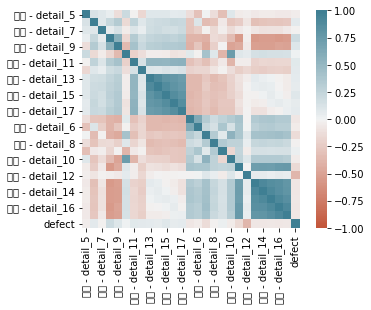

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# y = data_rate.iloc[:,2:]
# corr = y.corr()
# ax = sns.heatmap(
#     corr, 
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )

#Preprocess


In [ ]:
def fit_package(data_machine=data_machine, data_rate=data_rate):
  time_num = 3600
  data_machine.set_index("編號", inplace=True)
  all_data_machineId = np.array(data_machine.index.drop_duplicates(keep='first').values)
  data_machine.reset_index(inplace=True)

  data_rate.set_index("產生檢驗單號的時間", inplace=True)
  all_data_rateId = np.array(data_rate.index.drop_duplicates(keep='first').values)
  data_rate.reset_index(inplace=True)

  print(all_data_machineId.size)
  print(all_data_rateId.size)

  pkg_num = 0

  for data_rateId in all_data_rateId:
    time_compare = time_num
    data_machineId_compare = 0
    for data_machineId in all_data_machineId:
      """
      完全相同
      """
      # if data_machineId == data_rateId:
      #   pkg_num += 1 
      #   globals()['x_'+str(pkg_num)] = data_machine[data_machine["編號"] == data_machineId]
      #   globals()['y_'+str(pkg_num)] = data_rate[data_rate["產生檢驗單號的時間"] == data_rateId]
      # else:
      """
      完全相同&時間誤差一小時內視為同包
      """
      machineId = data_machineId[14:]  
      rateId = data_rateId[14:]
      
      if rateId == machineId:
        time_machine = datetime.strptime(data_machineId[0:13], "%Y%m%d%H:%M")
        time_rate = datetime.strptime(data_rateId[0:13], "%Y%m%d%H:%M")
        time_diff = (time_rate - time_machine).total_seconds()

        if time_diff <= 3600 and time_diff >= 0 and time_diff < time_compare:
          data_machineId_compare = data_machineId
          time_compare = time_diff
            
    if data_machineId_compare != 0:
      pkg_num += 1 
      # print(data_machineId_compare)
      globals()['x_'+str(pkg_num)] = data_machine[data_machine["編號"] == data_machineId_compare]
      globals()['y_'+str(pkg_num)] = data_rate[data_rate["產生檢驗單號的時間"] == data_rateId]
      globals()['z_'+str(pkg_num)] = data_rate["料號"][data_rate["產生檢驗單號的時間"] == data_rateId]
      globals()['t_'+str(pkg_num)] = pd.Series([time_compare])
  max_pkg_num = pkg_num
  print('Total package number:', max_pkg_num)
  return data_machine, data_rate, max_pkg_num


def to_sequence(data_machine, data_rate, max_pkg_num, sequence_num=100):
  usable_pkg = 0
  lessthan = 0
  

  for pkg_num in range(1, max_pkg_num+1):
    rateId = str(globals()['y_'+str(pkg_num)][["產生檢驗單號的時間"]].values[0][0][14:])
    machineIndex = int(globals()['x_'+str(pkg_num)].index[0])
    machineId = str(globals()['x_'+str(pkg_num)][["編號"]].values[0][0][14:]) #17-32

    for num in range(machineIndex,0,-1):
      features = data_machine.loc[[num]][['Speed', 'frequency', 'Status_0.0', 'Status_1.0', 'Status_2.0', 'Status_4.0']]
      if num == machineIndex:
        globals()['x_sequence_'+str(pkg_num)] = features
      else:
        # print(str(data_machine["編號"][num])[14:], machineId, type(str(data_machine["編號"][num])[14:])==type(machineId))
        # print('*'*200)
        if len(globals()['x_sequence_'+str(pkg_num)]) >= sequence_num:
          break
        else:
          if (str(data_machine["編號"][num])[14:] == machineId) and (len(globals()['x_sequence_'+str(pkg_num)]) < sequence_num):
          
            globals()['x_sequence_'+str(pkg_num)] = pd.concat([globals()['x_sequence_'+str(pkg_num)], features])
            # print(len(globals()['x_sequence_'+str(pkg_num)]))


  for pkg_num in range(1, max_pkg_num+1):
    if len(globals()['x_sequence_'+str(pkg_num)]) < sequence_num:
      lessthan += 1
    else:
      if usable_pkg == 0:
        first_pkg = pkg_num 
      usable_pkg += 1
    # globals()['x_sequence_'+str(pkg_num)] = globals()['x_sequence_'+str(pkg_num)].drop(["編號"], axis=1)
    globals()['y_sequence_'+str(pkg_num)] = globals()['y_'+str(pkg_num)].drop(["產生檢驗單號的時間","料號"], axis=1)
    globals()['z_sequence_'+str(pkg_num)] = globals()['z_'+str(pkg_num)]
    globals()['t_sequence_'+str(pkg_num)] = globals()['t_'+str(pkg_num)]
  """
  one hot encoding
  """
  # for pkg_num in range(1, max_pkg_num+1):
  #   if len(globals()['x_sequence_'+str(pkg_num)]) < sequence_num:
  #     pass
  #   else:
  #     globals()['x_sequence_'+str(pkg_num)] = pd.get_dummies(globals()['x_sequence_'+str(pkg_num)]).values
      

  # print(globals()['x_sequence_'+str(first_pkg)].shape)  
  # print(globals()['y_sequence_'+str(first_pkg)].shape)
  # print(globals()['z_sequence_'+str(first_pkg)].shape)
  # print(globals()['t_sequence_'+str(first_pkg)].shape)

  """
  依序存進data & label
  """
  count = 0
  for pkg_num in range(1, max_pkg_num+1):
    
    if len(globals()['x_sequence_'+str(pkg_num)]) < sequence_num:
      # print('n')
      pass
    else:
      # print('y')
      if pkg_num == first_pkg:

        data = pd.DataFrame(globals()['x_sequence_'+str(pkg_num)])
        label = pd.DataFrame(globals()['y_sequence_'+str(pkg_num)])    
        
        partno = pd.DataFrame(globals()['z_sequence_'+str(pkg_num)])    
        timediff = pd.DataFrame(globals()['t_sequence_'+str(pkg_num)])
      else:
        count+=1
        data = pd.concat([data, pd.DataFrame(globals()['x_sequence_'+str(pkg_num)])])
        label = pd.concat([label, pd.DataFrame(globals()['y_sequence_'+str(pkg_num)])])
        partno = pd.concat([partno, pd.DataFrame(globals()['z_sequence_'+str(pkg_num)])])
        timediff = pd.concat([timediff, pd.DataFrame(globals()['t_sequence_'+str(pkg_num)])])
      
     

  print(count)
  data = data.values

  label = label.values
  partno = partno.values
  timediff = timediff.values

  # print(data.shape) 
  # print(label.shape) 
  # print(partno.shape) 
  # print(timediff.shape)

  slide_size = 0
  pkg_size = 0
  data_temp = []
  data_temp1 = []
  label_temp = []

  for pkg_num in range(1, max_pkg_num+1):
    if len(globals()['x_sequence_'+str(pkg_num)]) < sequence_num:
      pass
    else: 
      data_temp.append(globals()['x_sequence_'+str(pkg_num)].values)
      label_temp.append(globals()['y_sequence_'+str(pkg_num)].values)
      
      
      # print(data[slide_size:(slide_size+sequence_num), :])
      # print(data[slide_size:(slide_size+sequence_num), 0:3])
      slide_size += sequence_num


  data = np.array(data_temp)
  label = np.array(label_temp)

  # print(data.shape)
  # print(label.shape)
  # print(partno.shape)
  # print(timediff.shape)

  return data, label, partno, timediff


In [ ]:
j = 0
for i in range(max_pkg_num):
  
  
  if len(globals()['x_sequence_'+str(i+1)]) != 20:
    print(globals()['x_sequence_'+str(i+1)])
    print('+'*200)
  else :

    j+=1
j

        Speed  frequency  Status_0.0  Status_1.0  Status_2.0  Status_4.0
213721   58.0       16.4           0           1           0           0
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
       Speed  frequency  Status_0.0  Status_1.0  Status_2.0  Status_4.0
27112  317.0   1.933333           0           1           0           0
27111  325.0   4.133333           0           1           0           0
27110  310.0   5.150000           0           0           1           0
27109  310.0   5.150000           0           0           1           0
27108  310.0   5.133333           0           0           1           0
27107  310.0   5.133333           0           0           1           0
27106  310.0   5.166667           0           0           1           0
27105  310.0   3.500000           0           0           1           0
27104

2718

#Model


LSTM

In [5]:
class BiLSTM_layer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional, batch_first=False):
        super(BiLSTM_layer, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=batch_first
        )

        self.fc = nn.Linear(hidden_size, 26)
        

    def forward(self, inputs):
        out, (h_n, c_n) = self.lstm(inputs, None)
        outputs = self.fc(torch.mean(h_n.squeeze(0), dim=0))

        return outputs



Encoder

In [6]:
class DataEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim=3,dropout=0.4):
    super(DataEncoder, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    
    self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                             nn.ReLU(),
                             nn.Dropout(dropout),
                             nn.Linear(hidden_dim, output_dim)
                            )
  def forward(self, x):
    return self.net(x)

class minmax_RuleEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim=3,dropout=0.4):
    super(minmax_RuleEncoder, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                             nn.ReLU(),
                             nn.Dropout(dropout),
                             nn.Linear(hidden_dim, output_dim)
                            )

  def forward(self, x):
    return self.net(x)

class outbound_RuleEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim=3,dropout=0.4):
    super(outbound_RuleEncoder, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                             nn.ReLU(),
                             nn.Dropout(dropout),
                             nn.Linear(hidden_dim, output_dim)
                            )

  def forward(self, x):
    return self.net(x)


In [ ]:
data_machine

,編號,Date,DayNight,OrderNo,product,time,no,ProdCount,Speed,Status,Weight,nonono,Unnamed: 12,lagProdCount,frequency
0,2020102608:01_101181728,20201026,1,101181728,0162B00100,10/26/2020 08:01:59,D-001,392,310.0,2.0,6499.6,101181728_D-001_1,20201026_101181728_D-001_1,83,5.150000
1,2020102608:02_101181728,20201026,1,101181728,0162B00100,10/26/2020 08:02:59,D-001,700,310.0,2.0,6499.6,101181728_D-001_1,20201026_101181728_D-001_1,392,5.133333
2,2020102608:03_101181728,20201026,1,101181728,0162B00100,10/26/2020 08:03:59,D-001,1008,310.0,2.0,6499.2,101181728_D-001_1,20201026_101181728_D-001_1,700,5.133333
3,2020102608:04_101181728,20201026,1,101181728,0162B00100,10/26/2020 08:04:59,D-001,1316,310.0,2.0,6499.2,101181728_D-001_1,20201026_101181728_D-001_1,1008,5.133333
4,2020102608:05_101181728,20201026,1,101181728,0162B00100,10/26/2020 08:05:59,D-001,1625,310.0,2.0,6499.0,101181728_D-001_1,20201026_101181728_D-001_1,1316,5.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222675,2021111609:53_200006806,20211116,0,200006806,0162B00100,11/16/2021 09:53:11,D-005,227410,301.0,2.0,6486.4,200006806_D-005_0,20211116_200006806_D-005_0,227107,5.050000
222676,2021111609:54_200006806,20211116,0,200006806,0162B00100,11/16/2021 09:54:11,D-005,227638,301.0,2.0,6487.8,200006806_D-005_0,20211116_200006806_D-005_0,227410,3.800000
222677,2021111609:55_200006806,20211116,0,200006806,0162B00100,11/16/2021 09:55:11,D-005,227940,301.0,2.0,6486.2,200006806_D-005_0,20211116_200006806_D-005_0,227638,5.033333
222678,2021111609:56_200006806,20211116,0,200006806,0162B00100,11/16/2021 09:56:11,D-005,228244,301.0,2.0,6488.2,200006806_D-005_0,20211116_200006806_D-005_0,227940,5.066667


Net

In [7]:
class Net(nn.Module):
  def __init__(self, input_dim, output_dim, minmax_rule_encoder, outbound_rule_encoder, data_encoder, hidden_dim=3, n_layers=1, merge='cat', skip=False, input_type='state'):
    super(Net, self).__init__()
    self.skip = skip
    self.input_type = input_type
    self.minmax_rule_encoder = minmax_rule_encoder
    self.outbound_rule_encoder = outbound_rule_encoder
    self.data_encoder = data_encoder
    self.n_layers = n_layers
    assert self.minmax_rule_encoder.input_dim ==  self.data_encoder.input_dim
    assert self.minmax_rule_encoder.output_dim ==  self.data_encoder.output_dim
    self.merge = merge
    if merge == 'cat':
      self.input_dim_decision_block = self.minmax_rule_encoder.output_dim * 3
    elif merge == 'add':
      self.input_dim_decision_block = self.minmax_rule_encoder.output_dim

    self.net = []
    for i in range(n_layers):
      if i == 0:
        in_dim = self.input_dim_decision_block
      else:
        in_dim = hidden_dim

      if i == n_layers-1:
        out_dim = output_dim
      else:
        out_dim = hidden_dim
      
      self.net.append(BiLSTM_layer(
              input_size=in_dim,
              hidden_size=64,
              num_layers=1,
              bidirectional=True,
              batch_first=True
          ))
    self.net = nn.Sequential(*self.net)

  def get_z(self, x, alpha=0.0, beta=0.0):
    minmax_rule_z = self.minmax_rule_encoder(x)
    outbound_rule_z = self.outbound_rule_encoder(x)
    data_z = self.data_encoder(x)

    if self.merge=='add':
      z = alpha * minmax_rule_z + beta * outbound_rule_z + (1-alpha-beta) * data_z    
    elif self.merge=='cat':
      z = torch.cat((alpha*minmax_rule_z , beta*outbound_rule_z , (1-alpha-beta)*data_z), dim=-1)   

    return z

  def forward(self, x, alpha=0.0, beta=0.0):
    minmax_rule_z = self.minmax_rule_encoder(x)
    outbound_rule_z = self.outbound_rule_encoder(x)
    data_z = self.data_encoder(x)

    if self.merge=='add':
      z = alpha*minmax_rule_z + beta*outbound_rule_z + (1-alpha-beta)*data_z   
    elif self.merge=='cat':
      z = torch.cat((alpha*minmax_rule_z , beta*outbound_rule_z , (1-alpha-beta)*data_z), dim=-1)  
    else:
      print(self.merge)
  
    if self.skip:
      if self.input_type == 'seq':
        return self.net(z) + x[:,-1,:]
      else:
        return self.net(z) + x    
    else:
      return self.net(z) 
      
      try:
        return self.net(z)   
      except:
        print(type(z))
        print(z.shape)

class DataonlyNet(nn.Module):
  def __init__(self, input_dim, output_dim, data_encoder, hidden_dim=4, n_layers=2, skip=False, input_type='state'):
    super(DataonlyNet, self).__init__()
    self.skip = skip
    self.input_type = input_type
    self.data_encoder = data_encoder
    self.n_layers = n_layers
    self.input_dim_decision_block = self.data_encoder.output_dim

    self.net = []
    for i in range(n_layers):
      if i == 0:
        in_dim = self.input_dim_decision_block
      else:
        in_dim = hidden_dim

      if i == n_layers-1:
        out_dim = output_dim
      else:
        out_dim = hidden_dim

      self.net.append(BiLSTM_layer(
            input_size=in_dim,
            hidden_size=64,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        ))
      
    self.net = nn.Sequential(*self.net)

  def get_z(self, x, alpha=0.0):
    data_z = self.data_encoder(x)

    return data_z

  def forward(self, x, alpha=0.0):
    data_z = self.data_encoder(x)
    z = data_z

    if self.skip:
      if self.input_type == 'seq':
        return self.net(z) + x[:,-1,:]
      else:
        return self.net(z) + x    
    else:
      return self.net(z)    

#Metrix

In [42]:
# def custom_mse(y_true, y_pred, alpha, beta):
#     alpha_loss=alpha
#     beta_loss=beta
    
#     loss_task = nn.MSELoss()(y_true, y_pred)
#     #loss_rule=  K.relu(y_pred[:,0] - 3.35)+K.relu(3.30 - y_pred[:,0])+K.relu(y_pred[:,1] - 2.3)+K.relu(2.2 - y_pred[:,1])+K.relu(y_pred[:,2] - 6.2)+K.relu(6.14 - y_pred[:,2])+K.relu(y_pred[:,3] - 2.77)+K.relu(2.63 - y_pred[:,3])+K.relu(y_pred[:,4] - 2.3)+K.relu(2.1 - y_pred[:,4])+K.relu(y_pred[:,5] - 3.37)+K.relu(3.23 - y_pred[:,5])+K.relu(y_pred[:,6] - 2.54)+K.relu(2.34 - y_pred[:,6])+K.relu(y_pred[:,7] - 0.42)+K.relu(0.38 - y_pred[:,7])+K.relu(y_pred[:,8] - 0.63)+K.relu(0.53 - y_pred[:,8])+K.relu(y_pred[:,9] - 0.63)+K.relu(0.53 - y_pred[:,9])+K.relu(y_pred[:,10] - 0.63)+K.relu(0.53 - y_pred[:,10])+K.relu(y_pred[:,11] - 0.63)+K.relu(0.53 - y_pred[:,11])+K.relu(y_pred[:,12] - 0.63)+K.relu(0.53 - y_pred[:,12])+K.relu(y_pred[:,13] - 3.35)+K.relu(3.30 - y_pred[:,13])+K.relu(y_pred[:,14] - 2.3)+K.relu(2.2 - y_pred[:,14])+K.relu(y_pred[:,15] - 6.2)+K.relu(6.14 - y_pred[:,15])+K.relu(y_pred[:,16] - 2.77)+K.relu(2.63 - y_pred[:,16])+K.relu(y_pred[:,17] - 2.3)+K.relu(2.1 - y_pred[:,17])+K.relu(y_pred[:,18] - 3.37)+K.relu(3.23 - y_pred[:,18])+K.relu(y_pred[:,19] - 2.54)+K.relu(2.34 - y_pred[:,19])+K.relu(y_pred[:,20] - 0.42)+K.relu(0.38 - y_pred[:,20])+K.relu(y_pred[:,21] - 0.63)+K.relu(0.53 - y_pred[:,21])+K.relu(y_pred[:,22] - 0.63)+K.relu(0.53 - y_pred[:,22])+K.relu(y_pred[:,23] - 0.63)+K.relu(0.53 - y_pred[:,23])+K.relu(y_pred[:,24] - 0.63)+K.relu(0.53 - y_pred[:,24])+K.relu(y_pred[:,25] - 0.63)+K.relu(0.53 - y_pred[:,25])
#     loss_rule_minmax= F.relu(y_pred[:,13] - y_pred[:,0])+F.relu(y_pred[:,14] - y_pred[:,1])+F.relu(y_pred[:,15] - y_pred[:,2])+F.relu(y_pred[:,16] - y_pred[:,3])+F.relu(y_pred[:,17] - y_pred[:,4])+F.relu(y_pred[:,18] - y_pred[:,5])+F.relu(y_pred[:,19] - y_pred[:,6])+F.relu(y_pred[:,20] - y_pred[:,7])+F.relu(y_pred[:,21] - y_pred[:,8])+F.relu(y_pred[:,22] - y_pred[:,9])+F.relu(y_pred[:,23] - y_pred[:,10])+F.relu(y_pred[:,24] - y_pred[:,11])+F.relu(y_pred[:,25] - y_pred[:,12])
#     loss_rule_outbound=F.relu((y_true[:,0] - 3.35)*(3.35-y_pred[:,0]))+F.relu((y_true[:,1] - 2.3)*(2.3-y_pred[:,1]))+F.relu((y_true[:,2] - 6.3)*(6.3-y_pred[:,2]))+F.relu((y_true[:,3] - 2.77)*(2.77-y_pred[:,3]))+F.relu((y_true[:,4] - 2.3)*(2.3-y_pred[:,4]))+F.relu((y_true[:,5] - 3.37)*(3.37-y_pred[:,5]))+F.relu((y_true[:,6] - 2.54)*(2.54-y_pred[:,6]))+F.relu((y_true[:,7] - 0.42)*(0.42-y_pred[:,7]))+F.relu((y_true[:,8] - 0.63)*(0.63-y_pred[:,8]))+F.relu((y_true[:,9] - 0.63)*(0.63-y_pred[:,9]))+F.relu((y_true[:,10] - 0.63)*(0.63-y_pred[:,10]))+F.relu((y_true[:,11] - 0.63)*(0.63-y_pred[:,11]))+F.relu((y_true[:,12] - 0.63)*(0.63-y_pred[:,12]))+F.relu((y_true[:,13] - 3.25)*(3.25-y_pred[:,13]))+F.relu((y_true[:,14] - 2.2)*(2.2-y_pred[:,14]))+F.relu((y_true[:,15] - 6.14)*(6.14-y_pred[:,15]))+F.relu((y_true[:,16] - 2.63)*(2.63-y_pred[:,16]))+F.relu((y_true[:,17] - 2.1)*(2.1-y_pred[:,17]))+F.relu((y_true[:,18] - 3.23)*(3.23-y_pred[:,18]))+F.relu((y_true[:,19] - 2.34)*(2.34-y_pred[:,19]))+F.relu((y_true[:,20] - 2.38)*(2.38-y_pred[:,20]))+F.relu((y_true[:,21] - 0.53)*(0.53-y_pred[:,21]))+F.relu((y_true[:,22] - 0.53)*(0.53-y_pred[:,22]))+F.relu((y_true[:,23] - 0.53)*(0.53-y_pred[:,23]))+F.relu((y_true[:,24] - 0.53)*(0.53-y_pred[:,24]))+F.relu((y_true[:,25] - 0.53)*(0.53-y_pred[:,25]))
#     # loss_rule_outbound=loss_rule_outbound*10

#     loss_rule_minmax = sum(loss_rule_minmax)
#     loss_rule_outbound = sum(loss_rule_outbound)

#     # print(y_true)
#     # print(y_pred)
#     # print('loss_task:', loss_task)
#     # print('loss_rule_minmax:', loss_rule_minmax)
#     # print('loss_rule_outbound:', loss_rule_outbound)

#     # print(loss)
#     loss= alpha_loss*loss_rule_minmax + beta_loss*loss_rule_outbound + (1-beta_loss-alpha_loss)*loss_task

#     return loss

def custom_mse(y_true, y_pred, alpha, beta):
    alpha_loss=alpha
    beta_loss=beta
    
    # print(y_true.shape)
    # print(y_pred.shape)
    loss_task = nn.MSELoss()(y_true, y_pred)
    #loss_rule=  K.relu(y_pred[:,0] - 3.35)+K.relu(3.30 - y_pred[:,0])+K.relu(y_pred[:,1] - 2.3)+K.relu(2.2 - y_pred[:,1])+K.relu(y_pred[:,2] - 6.2)+K.relu(6.14 - y_pred[:,2])+K.relu(y_pred[:,3] - 2.77)+K.relu(2.63 - y_pred[:,3])+K.relu(y_pred[:,4] - 2.3)+K.relu(2.1 - y_pred[:,4])+K.relu(y_pred[:,5] - 3.37)+K.relu(3.23 - y_pred[:,5])+K.relu(y_pred[:,6] - 2.54)+K.relu(2.34 - y_pred[:,6])+K.relu(y_pred[:,7] - 0.42)+K.relu(0.38 - y_pred[:,7])+K.relu(y_pred[:,8] - 0.63)+K.relu(0.53 - y_pred[:,8])+K.relu(y_pred[:,9] - 0.63)+K.relu(0.53 - y_pred[:,9])+K.relu(y_pred[:,10] - 0.63)+K.relu(0.53 - y_pred[:,10])+K.relu(y_pred[:,11] - 0.63)+K.relu(0.53 - y_pred[:,11])+K.relu(y_pred[:,12] - 0.63)+K.relu(0.53 - y_pred[:,12])+K.relu(y_pred[:,13] - 3.35)+K.relu(3.30 - y_pred[:,13])+K.relu(y_pred[:,14] - 2.3)+K.relu(2.2 - y_pred[:,14])+K.relu(y_pred[:,15] - 6.2)+K.relu(6.14 - y_pred[:,15])+K.relu(y_pred[:,16] - 2.77)+K.relu(2.63 - y_pred[:,16])+K.relu(y_pred[:,17] - 2.3)+K.relu(2.1 - y_pred[:,17])+K.relu(y_pred[:,18] - 3.37)+K.relu(3.23 - y_pred[:,18])+K.relu(y_pred[:,19] - 2.54)+K.relu(2.34 - y_pred[:,19])+K.relu(y_pred[:,20] - 0.42)+K.relu(0.38 - y_pred[:,20])+K.relu(y_pred[:,21] - 0.63)+K.relu(0.53 - y_pred[:,21])+K.relu(y_pred[:,22] - 0.63)+K.relu(0.53 - y_pred[:,22])+K.relu(y_pred[:,23] - 0.63)+K.relu(0.53 - y_pred[:,23])+K.relu(y_pred[:,24] - 0.63)+K.relu(0.53 - y_pred[:,24])+K.relu(y_pred[:,25] - 0.63)+K.relu(0.53 - y_pred[:,25])
    loss_rule_minmax= F.relu(y_pred[:,13] - y_pred[:,0])+F.relu(y_pred[:,14] - y_pred[:,1])+F.relu(y_pred[:,15] - y_pred[:,2])+F.relu(y_pred[:,16] - y_pred[:,3])+F.relu(y_pred[:,17] - y_pred[:,4])+F.relu(y_pred[:,18] - y_pred[:,5])+F.relu(y_pred[:,19] - y_pred[:,6])+F.relu(y_pred[:,20] - y_pred[:,7])+F.relu(y_pred[:,21] - y_pred[:,8])+F.relu(y_pred[:,22] - y_pred[:,9])+F.relu(y_pred[:,23] - y_pred[:,10])+F.relu(y_pred[:,24] - y_pred[:,11])+F.relu(y_pred[:,25] - y_pred[:,12])
    loss_rule_outbound=F.relu((y_true[:,0] - 3.35)*(3.35-y_pred[:,0]))+F.relu((y_true[:,1] - 2.3)*(2.3-y_pred[:,1]))+F.relu((y_true[:,2] - 6.3)*(6.3-y_pred[:,2]))+F.relu((y_true[:,3] - 2.77)*(2.77-y_pred[:,3]))+F.relu((y_true[:,4] - 2.3)*(2.3-y_pred[:,4]))+F.relu((y_true[:,5] - 3.37)*(3.37-y_pred[:,5]))+F.relu((y_true[:,6] - 2.54)*(2.54-y_pred[:,6]))+F.relu((y_true[:,7] - 0.42)*(0.42-y_pred[:,7]))+F.relu((y_true[:,8] - 0.63)*(0.63-y_pred[:,8]))+F.relu((y_true[:,9] - 0.63)*(0.63-y_pred[:,9]))+F.relu((y_true[:,10] - 0.63)*(0.63-y_pred[:,10]))+F.relu((y_true[:,11] - 0.63)*(0.63-y_pred[:,11]))+F.relu((y_true[:,12] - 0.63)*(0.63-y_pred[:,12]))+F.relu((y_true[:,13] - 3.25)*(3.25-y_pred[:,13]))+F.relu((y_true[:,14] - 2.2)*(2.2-y_pred[:,14]))+F.relu((y_true[:,15] - 6.14)*(6.14-y_pred[:,15]))+F.relu((y_true[:,16] - 2.63)*(2.63-y_pred[:,16]))+F.relu((y_true[:,17] - 2.1)*(2.1-y_pred[:,17]))+F.relu((y_true[:,18] - 3.23)*(3.23-y_pred[:,18]))+F.relu((y_true[:,19] - 2.34)*(2.34-y_pred[:,19]))+F.relu((y_true[:,20] - 0.38)*(0.38-y_pred[:,20]))+F.relu((y_true[:,21] - 0.53)*(0.53-y_pred[:,21]))+F.relu((y_true[:,22] - 0.53)*(0.53-y_pred[:,22]))+F.relu((y_true[:,23] - 0.53)*(0.53-y_pred[:,23]))+F.relu((y_true[:,24] - 0.53)*(0.53-y_pred[:,24]))+F.relu((y_true[:,25] - 0.53)*(0.53-y_pred[:,25]))
    loss_rule_outbound=loss_rule_outbound*10
   

    #print('alpha_loss',alpha_loss)
    #print('beta_loss',beta_loss)
    loss= alpha_loss*loss_rule_minmax + beta_loss*loss_rule_outbound + (1-beta_loss-alpha_loss)*loss_task

    return loss



# def measure_std(y_true, y_pred):

#   def transform(y_pred):
#     max_output = np.array(y_pred[:13])
#     min_output = np.array(y_pred[13:])
    
#     maxmin = max_output - min_output
#     if any(maxmin<0):
#       return 1
#     else :
#       return 0

#   def transform2(y):
#     max_std = np.array([3.35, 2.3, 6.3, 2.77, 2.3, 3.37, 2.54, 0.42, 0.63, 0.63, 0.63, 0.63, 0.63])
#     min_std = np.array([3.25, 2.20, 6.14, 2.63, 2.10, 3.23, 2.34, 0.38, 0.53, 0.53, 0.53, 0.53, 0.53])
 
#     max_output = np.array(y[:13])
#     min_output = np.array(y[13:])

#     if any(max_output>max_std) or any(min_output < min_std):
#       return 1 
#     else:
#       return 0    

#   defect = {}
  
#   y_true = y_true.cpu().detach().tolist()
#   y_pred = y_pred.cpu().detach().tolist()

#   true_defect_np = np.array(list(map(transform2, y_true)))
#   pred_defect_np = np.array(list(map(transform2, y_pred)))
#   # print(true_defect_np.shape,pred_defect_np.shape)
#   defect_np = np.array([1 if i == False else 0 for i in (true_defect_np == pred_defect_np)])
#   # print(defect_np)
#   minmax_np = np.array(list(map(transform, y_pred)))

#   assert defect_np.shape == minmax_np.shape, print(defect_np.shape, minmax_np.shape)

#   combine_np = [0 if i==0 else 1 for i in (defect_np + minmax_np)]

#   defect_acc = np.count_nonzero(defect_np==0) / len(defect_np)
#   all_acc = np.count_nonzero(combine_np==0) / len(combine_np)
#   defect['all'] = defect_acc
                                                                
  
  
  # for i in range(y_pred.shape[0]):
  #   # print(y_pred.shape[0])
  #   value = y_pred[i]
  #   for j in range(13):
  #     if (value[j] > max_std[j]) or (value[j+13] < min_std[j]):
  #       defect_list.append(1)
  #       break
  #     else:
  #       if j == 12:
  #         defect_list.append(0)
  
  # return defect

def measure_std(y_true, y_pred):
  y_true = y_true.cpu().detach().numpy()
  y_pred = y_pred.cpu().detach().numpy()
  
  max_std = [3.35, 2.3, 6.3, 2.77, 2.3, 3.37, 2.54, 0.42, 0.63, 0.63, 0.63, 0.63, 0.63]
  min_std = [3.25, 2.20, 6.14, 2.63, 2.10, 3.23, 2.34, 0.38, 0.53, 0.53, 0.53, 0.53, 0.53]
  std = max_std + min_std

  # max_std = [3.35, 2.3, 6.3, 2.77, 3.37, 2.54, 0.42, 2.3, 0.63, 0.63, 0.63, 0.63, 0.63]
  # min_std = [3.25, 2.20, 6.14, 2.63, 3.23, 2.34, 0.38, 2.10, 0.53, 0.53, 0.53, 0.53, 0.53]
 
  defect = []
  acc_list = []
  all = []
  pred_lists = []
  true_lists = []

  for i in range(26):
    true = y_true[:, i]
    pred = y_pred[:, i]

    pred_list = []
    true_list = []
 

    for j in range(y_pred.shape[0]):
      if i < 13:
   
        [pred_list.append(1) if pred[j]>std[j] else pred_list.append(0)]
        [true_list.append(1) if true[j]>std[j] else true_list.append(0)]   
       
      else:
        [pred_list.append(1) if pred[j]<std[j] else pred_list.append(0)]
        [true_list.append(1) if true[j]<std[j] else true_list.append(0)] 
   

    pred_lists += pred_list
    true_lists += true_list

    pred_np = np.array(pred_list)
    true_np = np.array(true_list)
    acc = (pred_np == true_np).sum() / len(pred_np)
    acc_list.append(acc)
    # defect[f'feature_{5+i}'] = acc

    all.append((pred_np == true_np))
  all_np = np.array(all)
  batch = all_np.shape[1]
  # print(type(batch))
  all_defect_np = np.array([1 if any(all_np[:, i]==False) else 0 for i in range(batch)])
  all_acc = np.count_nonzero(all_defect_np==0) / len(all_defect_np)
  
                                                                
  
  max_pred = y_pred[:, :13]
  min_pred = y_pred[:, 13:]

  tfPred = max_pred >= min_pred 

  for i in range(13):
    feature = tfPred[:, i]
    # print(feature)
    feature_acc = sum(feature) / len(feature)
    # print(sum(tfPred), len(tfPred))
    defect.append(feature_acc)
    # print(feature_acc)

  # for i in range(y_pred.shape[0]):
  #   # print(y_pred.shape[0])
  #   value = y_pred[i]
  #   for j in range(13):
  #     if (value[j] > max_std[j]) or (value[j+13] < min_std[j]):
  #       defect_list.append(1)
  #       break
  #     else:
  #       if j == 12:
  #         defect_list.append(0)
    
  
  return defect, all_acc, true_lists, pred_lists



#Train & val


In [43]:
def val(model, val_loader , device, alpha=0.0,beta=0.0):
    ''' Validation '''
    true_list = []
    pred_list = []
    val_list = []
    avg_acc_list = []
    defects = []
    avg_feature_accs = []
    record_dict = {}
    true_onehot = []
    pred_onehot = []

    model.eval()
  
    with torch.no_grad():

      for X_val, y_val in val_loader:
        X_val = X_val.to(torch.float32)
        X_val = X_val.to(device)
       
        y_val = y_val.to(torch.float32)
        y_val = y_val.to(device) 
 
        y_pred= model(X_val, alpha=alpha, beta=beta)
  
        val_loss=custom_mse(y_val, y_pred, alpha, beta)
        val_list.append(val_loss.sum().item())
  
        assert y_val.shape == y_pred.shape, print("shape not match")
  
        defect, acc, true_lists, pred_lists = measure_std(y_val, y_pred)
        defects.append(defect)
        avg_acc_list.append(acc)
        true_onehot += true_lists
        pred_onehot += pred_lists
        
        true_list += y_val.tolist()
        pred_list += y_pred.tolist()

      avg_val_loss = sum(val_list) / len(val_list)
      # record_dict['Val Loss'] = avg_val_loss
      avg_val_acc = sum(avg_acc_list) / len(avg_acc_list)
      # record_dict['Val Acc'] = avg_val_acc
      for i in range(13):
        col = np.array(defects)[:, i]
        avg_feature_acc = sum(col) / len(col) 
        record_dict[f'Val Acc_{i}'] = avg_feature_acc
        avg_feature_accs.append(avg_feature_acc)
      
 
    model.train()  
    return avg_val_loss, avg_val_acc, record_dict, true_list, pred_list, avg_feature_accs, true_onehot, pred_onehot


def train(model, optimizer, train_loader, device, scheduler=None, val_loader=None, alpha=0.0, beta=0.0,  epochs=1000, early_stopping_steps= 6000, type_='train' ):
  ''' Training '''

  lrs = []
  all_training_loss = []
  all_training_acc = []
  all_val_loss = []
  all_val_acc = []
  all_training_feature_acc = []
  all_val_feature_acc = []
  best = {}
  best_acc = 0
  early_stopping = 0
  steps = 0
  

  all_steps= epochs * len(train_loader)

  for epoch in range(1, epochs+1):

    model.train()
    with tqdm(total=len(train_loader), desc=f'Epoch{epoch}') as pbar:
      for X_train, y_train in train_loader:

        X_train = X_train.to(torch.float32)
        X_train = X_train.to(device)
        y_train = y_train.to(torch.float32)
        y_train = y_train.to(device)
        #batch_train_x=torch.reshape(batch_train_x, (-1, 300))
      
        optimizer.zero_grad()
        
        beta_param  = [0.1]
        if len(beta_param) == 1:
          alpha_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
          beta_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
        elif len(beta_param) == 2:  
          alpha_distribution = Beta(float(beta_param[0]), float(beta_param[1]))
          beta_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
        alpha = alpha_distribution.sample().item()
        # alpha=0
        # beta=0
        beta = beta_distribution.sample().item()
        
        if (alpha+beta)>=1:
          alpha=alpha/2
          beta=beta/2
        
        y_pred= model(X_train, alpha=alpha, beta=beta)

        # assert y_train.shape == y_pred, print(y_train)

        loss=custom_mse(y_train, y_pred, alpha, beta)

        train_defect, train_acc, true_lists, pred_lists = measure_std(y_train, y_pred)
        

        all_training_loss.append(loss.sum().item())
        all_training_acc.append(train_acc)
        all_training_feature_acc.append(train_defect)
    
        loss.sum().backward()
    
        
        # loss.backward()
        optimizer.step()

        if scheduler != None:
          scheduler.step()
        for param_group in optimizer.param_groups:
            lr = param_group['lr']
            lrs.append(lr)

        if type_ != 'test':
          assert val_loader != None, print('please enter val_loader')
          # Validation
          val_loss, avg_acc, record_dict, y_val, y_pred_val, val_defect, true_onehot, pred_onehot= val(model, val_loader, device, alpha=0, beta=0)
          all_val_loss.append(val_loss)
          all_val_acc.append(avg_acc)
          all_val_feature_acc.append(val_defect)


          # if val_loss < best_val_loss:
          #   early_stopping = 1
          #   best_val_loss = best_val_loss
          #   pbar.set_postfix({'Epoch': epoch, 'Loss': loss , 'Val Loss' : val_loss, 'Update': 'Best Model is update!!'})
          #   pbar.update(1)
          #   torch.save({
          #         'epoch': epoch,
          #         'model_state_dict':model.state_dict(),
          #         'optimizer_state_dict': optimizer.state_dict(),
          #         'loss': best_val_loss
          #       },'/content/drive/MyDrive/專案/羅明秀_大數據品管/model.pkl' )
            
          # else:
          #   early_stopping += 1
          #   pbar.set_postfix({'Epoch': epoch, 'Loss': loss , 'Val Loss' : val_loss})
          #   pbar.update()
          #   if early_stopping >= early_stopping_steps:
          #     return all_training_loss, all_val_loss

          # val_defect['Epoch'] = epoch
          # val_defect['Loss'] = loss.sum().item()
          # val_defect['Val Loss'] = val_loss
          # val_defect['Train acc'] = train_acc

          if avg_acc > best_acc:
            best_acc = avg_acc
            early_stopping = 1
            best['Acc'] = best_acc
            best['y_pred'] = y_pred_val
            best['y_true'] = y_val
            postfix = {'Epoch':epoch, 'LR': lr, 'Train Loss': loss.sum().item(), 'Train Acc': train_acc, 'Val loss':val_loss, 'Val Acc':avg_acc, 'Best Acc': best_acc }
            postfix.update(record_dict)
            pbar.set_postfix(postfix)
            pbar.update(1)
            # torch.save({
            #       'epoch': epoch,
            #       'model_state_dict':model.state_dict(),
            #       'optimizer_state_dict': optimizer.state_dict(),
            #       'loss': best_val_loss
            #     },'/content/drive/MyDrive/專案/羅明秀_大數據品管/model.pkl' )
            
          else:
            early_stopping += 1
            postfix = {'Epoch':epoch, 'LR': lr, 'Train Loss': loss.sum().item(), 'Train Acc': train_acc, 'Val loss':val_loss, 'Val Acc':avg_acc, 'Best Acc': best_acc }
            postfix.update(record_dict)
            pbar.set_postfix(postfix)
            pbar.update()
            if early_stopping > early_stopping_steps:
    
              return all_training_acc, all_training_loss, all_val_acc, all_val_loss, best, lrs, all_training_feature_acc, all_val_feature_acc
        else:
          pbar.update(1)
  if type_ == 'test':
    return model, optimizer, lrs
  else:
    return all_training_acc, all_training_loss, all_val_acc, all_val_loss, best, lrs, all_training_feature_acc, all_val_feature_acc
        





#DataLoader

In [10]:
def set_seed(myseed=42):
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(myseed)
  torch.manual_seed(myseed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(myseed)

def get_device():
  device = "cuda:0" if torch.cuda.is_available() else 'cpu'
  return device

def get_dataloader(X, y, batchs= 16):
  loader = DataLoader(TensorDataset(X, y), batch_size=batchs, shuffle=True)
  return loader

def get_model(seed, device, input_dim=6, output_dim_encoder=2, hidden_dim_encoder=64, output_dim=26, hidden_dim_db=64, n_layers=1, merge='cat'):
  set_seed(seed)
  minmax_rule_encoder = minmax_RuleEncoder(input_dim, output_dim_encoder, hidden_dim_encoder, dropout=0.2)
  set_seed(seed)
  outbound_rule_encoder = outbound_RuleEncoder(input_dim, output_dim_encoder, hidden_dim_encoder, dropout=0.2)
  set_seed(seed)
  data_encoder = DataEncoder(input_dim, output_dim_encoder, hidden_dim_encoder, dropout=0.2)
  set_seed(seed)
  model = Net(input_dim, output_dim, minmax_rule_encoder, outbound_rule_encoder, data_encoder, 
                        hidden_dim=hidden_dim_db, n_layers=n_layers, merge=merge).to(device)
  return model


def normalization(X_train_set, X_test_set):
  train_reshape_data = X_train_set.reshape((-1, 6))
  train_status = train_reshape_data[:, [2, 3, 4, 5]].reshape((-1, 20, 4))
  train_others = train_reshape_data[:, [0, 1]]
  test_reshape_data = X_test_set.reshape((-1, 6))
  test_status = test_reshape_data[:, [2, 3, 4, 5]].reshape((-1, 20, 4))
  test_others = test_reshape_data[:, [0, 1]]
  # print(test_status)
  scaler = MinMaxScaler()
  train_others_std = scaler.fit_transform(train_others).reshape((-1, 20, 2))
  test_others_std = scaler.transform(test_others).reshape((-1, 20, 2))

  X_train_set = np.concatenate([train_others_std, train_status], axis=2)
  X_test_set = np.concatenate([test_others_std, test_status], axis=2)
  

  return X_train_set, X_test_set

#Preprocess & CV

get data & label

In [12]:
data_machine, data_rate, max_pkg_num = fit_package(data_machine, data_rate)

data, label, partno, timediff = to_sequence(data_machine, data_rate, max_pkg_num, sequence_num=20)
print('data:', data.shape)
print('label:', label.shape)





NameError: ignored

In [13]:
np.save('/content/drive/MyDrive/羅明秀_大數據品管/data_20.npy', data)
np.save('/content/drive/MyDrive/羅明秀_大數據品管/label_20.npy', label)

NameError: ignored

In [ ]:
label_list = []
for i in label:
  input = i[0].tolist()
  label_list.append(input)

label = np.array(label_list)
np.save('/content/drive/MyDrive/羅明秀_大數據品管/label_20.npy', label)

In [ ]:
label.shape

split

In [ ]:
#split into training & testing set
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(data, label, random_state=42, train_size=0.9, shuffle=True)


model selection(optional)

In [ ]:
import logging
def get_logging(text):
  logging.basicConfig(level=logging.DEBUG)
  logging.info(text)

def cross_val(kfold=5, alpha=0.1, beta=0.1):
  device = get_device()
  ks = KFold(n_splits=kfold, random_state=42, shuffle=True)
  len_ = np.array(range(X_train_set.shape[0]))


  cv_loss = []
  cv_acc = []
  cv_best = {}
  cv_record = {}

  last_accs = []
  last_losses = []

  # cross validation
  for idx, index in enumerate(ks.split(len_)):
    
    get_logging(f'Start Training CV {idx}')
    train_index, val_index = index
    X_train = X_train_set[train_index, :, :]
    # print(X_train)
    X_val = X_train_set[val_index, :, :]
    X_train, X_val = normalization(X_train, X_val )
    
    # print(X_val)
    # print(X_train)
    X_train = torch.tensor(X_train)
    X_val = torch.tensor(X_val)
    y_train = torch.tensor(y_train_set[train_index,  :])
    y_val = torch.tensor(y_train_set[val_index, :])
    # print('X_train:', X_train)
    # print('y_train:', y_train)
    # print('X_val:', X_val)
    # print('y_val:', y_val)
    train_loader = get_dataloader(X_train, y_train)
    val_loader = get_dataloader(X_val, y_val)
    model = get_model(seed=42, device=device)


    optimizer = optim.AdamW(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

    all_training_acc, all_training_loss, all_val_acc, all_val_loss, best, lrs, all_training_feature_acc, all_val_feature_acc = train(model=model, 
                                                                        scheduler=scheduler,
                                                                        optimizer=optimizer,
                                                                        train_loader=train_loader, 
                                                                        val_loader=val_loader,
                                                                        early_stopping_steps = 2000,
                                                                        alpha = alpha,
                                                                        beta = beta, 
                                                                        device=device, 
                                                                        type_=None)
    # cv_loss.append(best_val_loss)
    best_acc = best['Acc']
    cv_acc.append(best_acc)
    cv_best[f'cv{idx}'] = best
    cv_record[f'train_acc_cv{idx}'] = all_training_acc
    cv_record[f'val_acc_cv{idx}'] = all_val_acc
    cv_record[f'train_loss_cv{idx}'] = all_training_loss
    cv_record[f'val_loss_cv{idx}'] = all_val_loss
    cv_record[f'train_feature_acc{idx}'] = all_training_feature_acc
    cv_record[f'val_feature_acc{idx}'] = all_val_feature_acc

    get_logging(f'Best Accuracy: {best_acc}')
    get_logging(f'Finish Training CV {idx}\n')

    last_accs.append(all_val_acc[-1])
    last_losses.append(all_val_loss[-1])
  
  avg_last_acc = sum(last_accs) / len(last_accs)
  avg_last_loss = sum(last_losses) / len(last_losses)

  return cv_record, avg_last_acc, avg_last_loss


def search_alpha_beta():
  alphas = [i/10 for i in range(0, 11, 1)]
  betas = [i/10 for i in range(0, 11, 1)]
  all_acc = []
  best_acc = -1
  best_alpha = -1
  best_beta = -1
  
  with tqdm(total=len(alphas)*len(betas), desc='Load') as pbar:
    for i in alphas:

      # certain alpha vs all beta
      alpha_acc = []
      for j in betas:
        cv_reord, avg_last_acc, avg_last_loss = cross_val(kfold=5, alpha=i, beta=j)
        alpha_acc.append(avg_last_acc)
        if avg_last_acc > best_acc:
          best_alpha = i
          best_beta = j
          best_acc = avg_last_acc
        pbar.set_postfix({'Alpha':i, 'Beta': j, 'Accuracy': avg_last_acc, 'Best': f'{best_alpha} {best_beta} {best_acc}'})
        pbar.update(1)
      all_acc.append(alpha_acc)
      #row=alpha values, columns=beta values

    np.save('/content/drive/MyDrive/羅明秀_大數據品管/all_acc.npy', np.array(all_acc))

    print('Best Alpha:', best_alpha)
    print('Best Beta:', best_beta)
    print('Best Accuracy:', best_acc)



search_alpha_beta()
  

  



Epoch1: 100%|██████████| 123/123 [00:28<00:00,  4.39it/s, Epoch=1, LR=0.00884, Train Loss=1.02, Train Acc=0, Val loss=0.422, Val Acc=0.12, Best Acc=0.475, Val Acc_0=1, Val Acc_1=1, Val Acc_2=0, Val Acc_3=1, Val Acc_4=0, Val Acc_5=0, Val Acc_6=1, Val Acc_7=1, Val Acc_8=0, Val Acc_9=0, Val Acc_10=0, Val Acc_11=1, Val Acc_12=0.437]

Epoch2: 100%|██████████| 123/123 [00:30<00:00,  4.10it/s, Epoch=2, LR=0.00782, Train Loss=0.193, Train Acc=0, Val loss=0.18, Val Acc=0.121, Best Acc=0.513, Val Acc_0=0, Val Acc_1=1, Val Acc_2=0, Val Acc_3=1, Val Acc_4=0, Val Acc_5=0, Val Acc_6=0, Val Acc_7=1, Val Acc_8=0, Val Acc_9=1, Val Acc_10=1, Val Acc_11=0.129, Val Acc_12=0]

Epoch3: 100%|██████████| 123/123 [00:30<00:00,  4.07it/s, Epoch=3, LR=0.00691, Train Loss=0.934, Train Acc=0.25, Val loss=0.144, Val Acc=0.233, Best Acc=0.816, Val Acc_0=1, Val Acc_1=1, Val Acc_2=1, Val Acc_3=1, Val Acc_4=1, Val Acc_5=1, Val Acc_6=1, Val Acc_7=0, Val Acc_8=1, Val Acc_9=1, Val Acc_10=1, Val Acc_11=0, Val Acc_12=1]

Ep

In [ ]:
#save data
with open('/content/drive/MyDrive/專案/羅明秀_大數據品管/acc.json', 'w') as f:
 json.dump(cv_record, f)

avg_cv_acc = sum(cv_acc) / len(cv_acc)
print('\n CV Accuracy:\n', avg_cv_acc)

# import json 
# with open('/content/drive/MyDrive/專案/羅明秀_大數據品管/acc.json', newline='') as f:
  # data = json.load(f)


In [ ]:
# which cv
cv = 0
train_acc = cv_record[f'train_acc_cv{cv}']
val_acc = cv_record[f'val_acc_cv{cv}']
train_loss = cv_record[f'train_loss_cv{cv}']
val_loss = cv_record[f'val_loss_cv{cv}']
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.title(f'CV = {cv}')
plt.legend()
plt.xlabel('Round(Each Batch)')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Val')

plt.title(f'CV = {cv}')
plt.legend()
plt.xlabel('Round(Each Batch)')
plt.ylabel('Loss')
plt.show()

In [ ]:
cv = 0
feature = 12
train_f = cv_record[f'train_feature_acc{cv}']
val_f = cv_record[f'val_feature_acc{cv}']
train_feature_acc = np.array(train_f)[:, feature]
val_feature_acc = np.array(val_f)[:, feature]

plt.plot(train_feature_acc, label='Train')
plt.plot(val_feature_acc, label ='Val' )
plt.legend()
plt.title(f'Cv={cv}, Feature={feature}')
plt.ylabel('Accuracy')
plt.xlabel('Round(Each Batch)')
plt.show()

#start training

In [16]:
data = np.load('/content/drive/MyDrive/羅明秀_大數據品管/data_20.npy').reshape((-1, 20, 6))
label = np.load('/content/drive/MyDrive/羅明秀_大數據品管/label_20.npy')

#split into training & testing set
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(data, label, random_state=42, train_size=0.9, shuffle=True)


In [44]:
X_train_set, X_test_set = normalization(X_train_set, X_test_set)
train_loader = get_dataloader(torch.tensor(X_train_set), torch.tensor(y_train_set))

device = get_device()
model = get_model(seed=42, device=device)
optimizer = optim.AdamW(model.parameters(), lr=0.01)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999) 
model, optimizer, lrs = train(model=model, optimizer=optimizer, scheduler=scheduler, train_loader=train_loader, alpha=0.1, device=device, epochs=200, type_='test')


Epoch200: 100%|██████████| 153/153 [00:02<00:00, 65.00it/s]


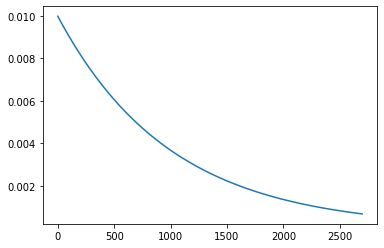

In [ ]:
plt.plot(lrs)

testing

In [45]:
test_loader = get_dataloader(torch.tensor(X_test_set), torch.tensor(y_test_set))
avg_test_loss, avg_acc, defect, y_test, y_pred, feature_acc, true_onehot, pred_onehot = val(model, test_loader, device)
print('Testing Accuracy:')
print(avg_acc)

Testing Accuracy:
0.9448529411764706


confusion matrix

Text(0.5, 1.0, 'Confusion Matrix')

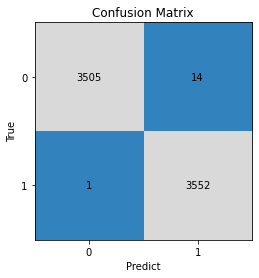

In [46]:
grid = confusion_matrix(true_onehot, pred_onehot)
fig, ax = plt.subplots()
for (j,i),label in np.ndenumerate(grid):
  ax.text(i,j,label,ha='center',va='center')
ax.imshow(grid, cmap = 'tab20c')
ax.set_xticks([1, 0])
ax.set_yticks([1, 0])
ax.set_xlabel('Predict')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')

In [41]:
true_onehot == pred_onehot

True

In [ ]:
y_pred_np = np.array(y_pred)
max_pred = y_pred_np[:, :13]
min_pred = y_pred_np[:, 13:]
(max_pred < min_pred).sum(axis=0)
# max_pred[:, 0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
test_loader = get_dataloader(torch.tensor(X_test_set), torch.tensor(y_test_set))
for i in test_loader:
  print(i)
  break

[tensor([[[7.7305e-01, 3.2524e-02, 1.0000e+00],
         [7.3759e-01, 1.2557e-01, 2.0000e+00],
         [7.3759e-01, 1.2680e-01, 2.0000e+00],
         ...,
         [7.3759e-01, 1.2721e-01, 2.0000e+00],
         [7.3759e-01, 1.6468e-03, 2.0000e+00],
         [7.7305e-01, 1.4821e-02, 1.0000e+00]],

        [[7.7305e-01, 1.1198e-01, 1.0000e+00],
         [7.3759e-01, 1.2639e-01, 2.0000e+00],
         [7.3759e-01, 1.2680e-01, 2.0000e+00],
         ...,
         [7.3759e-01, 9.6336e-02, 2.0000e+00],
         [7.7305e-01, 1.0416e-01, 1.0000e+00],
         [7.3759e-01, 1.2639e-01, 2.0000e+00]],

        [[7.9433e-01, 1.3668e-01, 2.0000e+00],
         [7.9433e-01, 7.9045e-02, 2.0000e+00],
         [8.3452e-01, 3.8287e-02, 1.0000e+00],
         ...,
         [7.9433e-01, 1.3627e-01, 2.0000e+00],
         [7.9433e-01, 1.3668e-01, 2.0000e+00],
         [7.9433e-01, 3.8699e-02, 2.0000e+00]],

        ...,

        [[8.0142e-01, 5.8460e-02, 1.0000e+00],
         [7.6123e-01, 1.3215e-01, 2.0000e+00

In [ ]:
max_pred[:, -6]

array([0.41177893, 0.41219869, 0.41219175, 0.41219437, 0.41190058,
       0.4115926 , 0.41175729, 0.41158119, 0.4121587 , 0.41219258,
       0.41219088, 0.41218719, 0.41219449, 0.4115932 , 0.41159305,
       0.41177142, 0.41219369, 0.4121927 , 0.41219428, 0.41157928,
       0.41220042, 0.41156924, 0.41219461, 0.41158819, 0.4115932 ,
       0.41148409, 0.411174  , 0.4117775 , 0.41177684, 0.41218477,
       0.4115966 , 0.41214541, 0.41219619, 0.411594  , 0.41159323,
       0.41159308, 0.41117519, 0.41159239, 0.41159162, 0.41157952,
       0.41177589, 0.41159287, 0.41217956, 0.41159546, 0.41177893,
       0.41177675, 0.41189983, 0.41159311, 0.41159454, 0.41219717,
       0.41219375, 0.41216567, 0.41220018, 0.41159332, 0.41159797,
       0.4117789 , 0.411309  , 0.41219735, 0.41158891, 0.41159475,
       0.41219553, 0.41220149, 0.41159141, 0.41219437, 0.41128469,
       0.41219184, 0.41159785, 0.41129139, 0.41215968, 0.41215709,
       0.41219682, 0.41218898, 0.41159394, 0.411769  , 0.41159

In [ ]:
min_pred[:,-6]

array([0.39069158, 0.39126682, 0.39126042, 0.39126649, 0.39088932,
       0.39121163, 0.39126495, 0.39122349, 0.39129612, 0.39126626,
       0.39128155, 0.39127988, 0.39126644, 0.39121166, 0.39121297,
       0.39125186, 0.3912645 , 0.39126602, 0.39126199, 0.39122623,
       0.39126986, 0.39124498, 0.39126641, 0.39120635, 0.39121324,
       0.39087728, 0.3906377 , 0.39069316, 0.39069232, 0.3912783 ,
       0.39121166, 0.39130422, 0.39126623, 0.39121225, 0.391213  ,
       0.39121294, 0.39063966, 0.39121342, 0.39121148, 0.39122495,
       0.39069325, 0.39121351, 0.39127195, 0.39121351, 0.39069557,
       0.39069277, 0.39089158, 0.39121237, 0.39121348, 0.39126492,
       0.39126664, 0.391303  , 0.39126754, 0.39121327, 0.39121374,
       0.3906962 , 0.39083204, 0.39126632, 0.39121327, 0.39121124,
       0.39126176, 0.3912839 , 0.3912119 , 0.39126647, 0.39085737,
       0.39126283, 0.39121413, 0.39087349, 0.39130098, 0.39130008,
       0.39126399, 0.39128035, 0.39121363, 0.39125749, 0.39121